In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os.path
import numpy as np

# This is empirically verified, DO NOT MODIFY
PEAK_REL_AMP = 0.563
PEAK_REL_AMP_DB = 20. * np.log10(PEAK_REL_AMP)

# Verify WAV stimuli for MEG experiment
* This Notebook will take any outlier there is in your WAV-files.
    * If it has an amplitude that's too big, this Notebook will recommend a number of dB to attenuate with, so that specific outlier "fits"
    * It will not take in mind that it is an outlier and the proposed attenuation will therefor be too much for the rest of your WAV-file.

WAV-files used in the MEG should

* be sampled at 44.1 kHz
* be saved as 16-bit integer precision

If this notebook runs without error, that is the case. In addition, the final plot can be inspected to see the largest absolute amplitude of the stimulus set used. Due to mismatches between the input- and output-levels of the various components in the audio-stream:

 > __the peak amplitude should never exceed 0.563 (-4.99 dB), _i.e._, 56.3% of maximum volume output__
 
 ## Prerequisites

You must have the module `meeg-python` in your Python path. A stable version is installed on the servers, but you may also want to clone a copy of the module into your project-folder. If you do so, remember to add the copy to your path. In a notebook, you can achieve this by:

```python
import sys
sys.path.insert(0, '/path/to/your/local/copy/of/meeg-python)
```
 


### Why should I verify my WAV stimuli before the MEG experiment?
Running this next cell, will show a sine-wave with 2000 V A, getting cut off at 1100V A.
This is what will happen to your WAV stimuli, if the WAV file doesn't get attenuated enough.

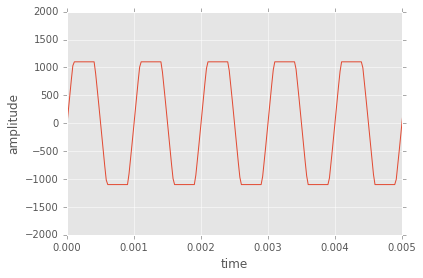

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fs = 44100
t = np.arange(-0.002, .02, 1.0/fs)
f0 = 1000
A = 2000
x = A * np.sin(2 * np.pi * f0 * t )
clipped = np.clip(x,-1100,1100)
plt.plot(t, clipped)
plt.axis([0, 0.005,-2000, 2000])
plt.xlabel('time')
plt.ylabel('amplitude')
plt.show()

 ### File layout
 To test your own stimuli, you need to set the path to stimuli.
* Set the `proj_name` to your project.
* Place all the WAV files in a single folder, and set the variable `wav_stimuli` (below) to point to it.

In [4]:
proj_name = 'MEG_EEG-Training'
wav_stimuli = 'wav_stimuli'
wavdir = os.path.join('/aux', proj_name, wav_stimuli)

In [5]:
if not os.path.exists(os.path.expanduser(wavdir)):
    raise IOError('Invalid wav-directory: {:s}'.format(wavdir))

In [6]:
from meeg.wavhelpers import (list_wavs_in_dir, get_wav, wavlist_to_wavarr)
Fs = 44100.  # get_wav hard-coded to raise error if not 44.1 kHz

### Get a list of pathnames to the WAV-files

In [7]:
wavnames = list_wavs_in_dir(wavdir)

### Read each WAV into memory

Each file is read into a list of 2D-arrays, after which we know the duration of the longest stimulus. The function `wavlist_to_wavarr` then zero-pads each array to have equal duration, and returns a 3D array with dimensions `n_files x n_channels x n_timepoints`, where `n_channels` is either 1 (mono) or 2 (stereo).

In [8]:
wavlist = []
for fname in wavnames:
    wavlist += [get_wav(fname)]
wavarr = wavlist_to_wavarr(wavlist)
del wavlist

# now data is guaranteed to be 16 bit short
maxVal = 2**15 - 1

/usr/local/common/anaconda/lib/python2.7/site-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


### Plot every N:th WAV-file

Currently plots only left channel.

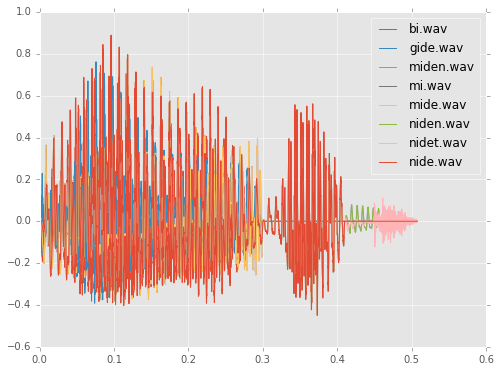

In [9]:
plot_every_nth = 2
timepoints = np.arange(0, wavarr.shape[2]/Fs, 1./Fs)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for nwav in range(0, wavarr.shape[0], plot_every_nth):
    ax.plot(timepoints, wavarr[nwav,0,:].astype(float) / np.float(maxVal),
            label=os.path.basename(wavnames[nwav]))
ax.legend()

## The stimulus envelope (peak value)

In [10]:
# max_env = np.abs(wavarr).max(axis=0).astype(float) / np.float(maxVal)
max_env = 20. * np.log10(np.abs(wavarr).max(axis=0).astype(float) /
                         np.float(maxVal))
max_stim_env = max_env.max()
print('The maximum stimulus envelope is {:.3f} '
      '({:.3f} dB)'.format(10**(max_stim_env / 20.), max_stim_env))

The maximum stimulus envelope is 0.889 (-1.025 dB)


## A plot of the peak range for all stimuli

This plots the peak absolute values of the stimuli, in dB relative to the maximum possible in the 16-bit wav file.

/usr/local/common/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


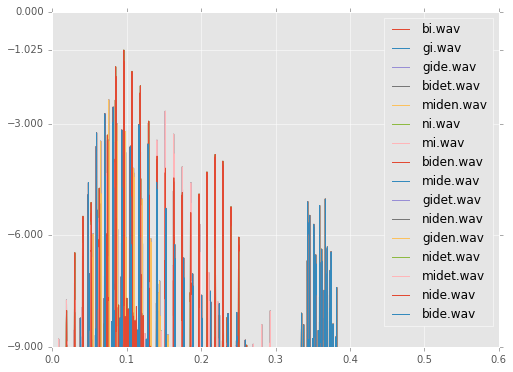

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for ww in range(wavarr.shape[0]):
    ax.plot(timepoints, 
            20. * np.log10(np.abs(wavarr[ww, 0, :]).astype(float) /
                           np.float(maxVal)),
            label=os.path.basename(wavnames[ww]))
ax.set_ylim(-9., 0.)
ax.legend()
_ = ax.set_yticks([0., max_stim_env, -3., -6., -9.])

## What should I do with my stimuli?

Now that you know the peak envelope of your stimulus set, we can calculate whether and how much additional dampening of the stimuli is required for no clipping to occur.

In [12]:
att_factor = PEAK_REL_AMP / 10**(max_stim_env / 20.)
if max_stim_env > PEAK_REL_AMP_DB:
    print('You should attenuate your stimuli by '
          'a factor of {:.3f} ({:.3f} dB)'.format(att_factor,
                                                  20 * np.log10(att_factor)))
else:
    print('Your stimuli are sufficiently damped, '
          'you are using {:.1f}% of the range.'.format(100./att_factor))

You should attenuate your stimuli by a factor of 0.634 (-3.965 dB)
